In [1]:
import numpy as np
import xarray as xr

import rasterio.features
import stackstac
import pystac_client
import planetary_computer

import xrspatial.multispectral as ms

from skimage.feature import graycomatrix, graycoprops
from skimage import data
import pandas as pd
import geopandas as gpd
from datetime import datetime
from shapely.geometry import shape
import shapely
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns



# Localized sandsnap texture generation from NAIP


Hypothesis:  VHR resolution satellite imagery (like NAIP) maybe good enough to see a correlation between image texture features (extracted from GLCMs) and sand grain size distribution


In this notebook, we extract median sand grain sizes (D50) from a single beach in NY, USA: Jones Beach. This beach has 52 observations spatially spread out across this beach taken in June 2021, and found in the file `data/sandsnap-jones-beach.csv`. Using the NAIP imagery from this beach, we will try to verify if there is a correlation b/w D50 and some GLCM features.

## Step 1

Extract SandSnap data to a pandas dataframe. Clean the dataframe, rename columns and drop unused columns

Clean the date format

In [2]:
sandsnap_df = pd.read_csv('../data/sandsnap-cont-usa.csv')
sandsnap_df['date'] =  pd.to_datetime(sandsnap_df['CreationDate'], format='%m/%d/%y',infer_datetime_format=True).dt.date
sandsnap_df.head()

,objectid,GlobalID,City,Sample ID,Coin Reference,Location on Beach,Other,CreationDate,Creator,EditDate,...,blurry_metric,ab_value,pixel_count,reprocess_record,reprocess_all_records,Calculated Grain Size,Analysis Status,x,y,date
0,925,fffbb2f3-562f-4ffa-8338-fe958bae327d,Gulfport,NaN,quarter,the_berm,NaN,11/12/22 14:16,NaN,11/12/22 14:18,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-89.043261,30.377676,2022-11-12
1,261,de1184c4-f446-4e58-9016-94cdbd0cfc15,Ocean Beach,Ocean Beach #6,nickel,the_swash,NaN,9/15/21 15:16,rose.dopsovic,2/28/22 18:43,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-122.511641,37.757227,2021-09-15
2,238,cf0a6f1c-b15d-4aa9-8ea6-55bba28b9d47,Key West,NaN,quarter,the_berm,NaN,9/15/21 15:16,rose.dopsovic,2/28/22 18:43,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-81.809414,24.545279,2021-09-15
3,215,829ed0e3-ef7c-4286-99d0-1dab6575f449,St. Augustine,St. Augustine berm,quarter,the_berm,the_berm,9/14/21 18:51,rose.dopsovic,8/22/22 15:55,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-81.264700,29.854100,2021-09-14
4,547,caf789b9-bcb9-46f5-8d71-64ee4e853e07,Racine,NaN,quarter,the_swash,NaN,5/3/22 16:05,NaN,5/3/22 16:12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-87.779766,42.739346,2022-05-03


### Summary stats for grain size params

In [3]:
sandsnap_df[['D10 mm','D50 mm','D90 mm','DMEAN mm']].describe()

,D10 mm,D50 mm,D90 mm,DMEAN mm
count,644.000000,644.000000,644.000000,644.000000
mean,0.411976,0.624489,1.015473,0.629203
std,0.191127,0.289772,0.471224,0.291952
min,0.057823,0.087542,0.142285,0.088223
25%,0.302079,0.458364,0.745488,0.461785
50%,0.395184,0.601012,0.977464,0.605371
75%,0.499827,0.761318,1.236901,0.767170
max,2.368181,3.595201,5.848548,3.621643


array([[<AxesSubplot:title={'center':'D10 mm'}>,
        <AxesSubplot:title={'center':'D50 mm'}>],
       [<AxesSubplot:title={'center':'D90 mm'}>,
        <AxesSubplot:title={'center':'DMEAN mm'}>]], dtype=object)

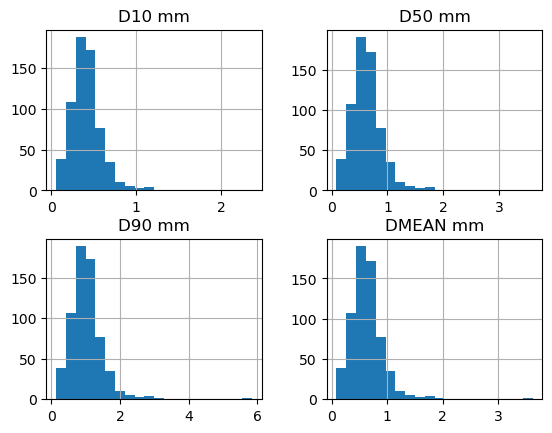

In [4]:
sandsnap_df[['D10 mm','D50 mm','D90 mm','DMEAN mm']].hist(bins=20)

In [5]:
sandsnap_df.dtypes

objectid                                                                                   int64
GlobalID                                                                                  object
City                                                                                      object
Sample ID                                                                                 object
Coin Reference                                                                            object
Location on Beach                                                                         object
Other                                                                                     object
CreationDate                                                                              object
Creator                                                                                   object
EditDate                                                                                  object
Editor                        

### Organize dataframe

In [6]:
usa = sandsnap_df[['objectid','D10 mm','D50 mm','D90 mm','DMEAN mm','Processing Status','date','x','y']]
usa = usa[usa['Processing Status'] == 'ok'].drop('Processing Status',axis='columns')
usa = usa.rename(columns={'D90 mm':'D90','D50 mm':'D50','D10 mm':'D10','DMEAN mm':'DMEAN','x':'lon', 'y':'lat'}) #Rename the field
usa.head()

,objectid,D10,D50,D90,DMEAN,date,lon,lat
0,925,0.255204,0.386369,0.627979,0.389373,2022-11-12,-89.043261,30.377676
1,261,0.423573,0.645732,1.052281,0.649902,2021-09-15,-122.511641,37.757227
2,238,0.295365,0.447742,0.728023,0.451138,2021-09-15,-81.809414,24.545279
3,215,0.369014,0.559148,0.909059,0.563421,2021-09-14,-81.264700,29.854100
4,547,0.419892,0.635700,1.033225,0.640642,2022-05-03,-87.779766,42.739346


## Iterate over each entry and analyze

We will use a naive extraction method, which will be wasteful because these coordinates are likely to be covered by one or few NAIP tiles. But for the sake of simplicity, we will extract the NAIP tile that overlaps with each coordinate, and construct the texture features


In [7]:
side_len_deg = 0.0001 #~11.1m

In [8]:
def bbox(lon, lat, side_len_deg = 0.0001):
    point_geom  = shapely.geometry.mapping(shapely.geometry.Point(lon, lat))
    point_shape = shapely.geometry.shape(point_geom)
    #Create a square out of it with side_length = buffer*2
    mask_shape  = point_shape.buffer(side_len_deg/2.).envelope
    aoi   = shapely.geometry.mapping(mask_shape)
    return aoi
    # return rasterio.features.bounds(aoi)

Using pystac_client we can search the Planetary Computer's STAC endpoint for items matching our query parameters.

## Functions to extract NAIP tiles for each entry

In [9]:
collection = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

In [10]:
#returns the closest date 
def nearest_date(items, pivot):
    return min(items, key=lambda x: abs(x - pivot))

To select the nearest time to a desired time value, we set it to use a nearest neighbour method, 'nearest'. We have to specify the time using a datetime object. [ref](https://docs.digitalearthafrica.org/en/latest/sandbox/notebooks/Frequently_used_code/Working_with_time.html)

TODO:
1. Select closest date
2. Check for rainfall near that date - some temporal buffer


In [11]:
import operator

def cropCenter(img, bounding):
    start = tuple(map(lambda a, da: a//2-da//2, img.shape, bounding))
    end = tuple(map(operator.add, start, bounding))
    slices = tuple(map(slice, start, end))
    return img[slices]

In [12]:
import pyproj

GSD = 10.0 #m/px

def area_of_overlap(item, aoi):
    area_shape = shape(aoi)
    aoi_area = area_shape.area
    
    
    aoi_area = shape(aoi).area
    
    overlap_area = shape(item.geometry).intersection(shape(aoi)).area
    # print(aoi_area, overlap_area)
    return overlap_area / aoi_area


def S2_data(date, lon, lat, bands = ["B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B11", "B12"],\
            limit_months=5, window_size_px=10, add_to_map=None):
    """
    parameters:
    date: datetime object of the time of observation capture
    lon, lat : coordinates of observation
    bands : list of Sentinel 2 band names
    limit_months : maximum duration before and after date to search for
    buffer : area to crop around (lon,lat) in meters, i.e. a square with side buffer
    
    return type:
    window_size_px : if > 1, will return a numpy array DN values at all pixels within window
            if 1, will return a list of DN values per band at that pixel
    """
    
    #Create a window of limit_months around the acquisition date to search for NAIP data
    start_date, end_date = date - relativedelta(months=int(limit_months/2)), \
                            date + relativedelta(months=int(limit_months/2))


    date_range = start_date.strftime('%Y-%m-%d') + "/" + end_date.strftime('%Y-%m-%d')
    
    aoi = bbox(lon, lat)

    search = collection.search(
        # bbox=aoi, 
        intersects=aoi,
        datetime=date_range,
        collections=["sentinel-2-l2a"],
        query={"eo:cloud_cover": {"lt": 20}},
        limit=10,
    )
    
    items = search.item_collection()
    
    if len(items) == 0:
        print ("No tiles found in ", date_range)
        return None
    
    if len(items) > 0:
        tile = items[0]
    else:
        tile = items
        
#     display(tile)
    
#     print(len(items))
        
    delta_days = abs((tile.datetime.date() - date).days)
    
    if len(items) > 0:
        delta_min = 1e9
        
        #Choose the item that's closest in time to the sandsnap item's
        for i, item in enumerate(items):
            delta_days = abs((item.datetime.date() - date).days)
            # print(delta_days)
            if delta_days < delta_min:
                delta_min = delta_days
                tile = item
                
    #Make sure area of overlap is 100%
    if area_of_overlap(tile,aoi) != 1:
        return None
    
    # print("{:} overlapping tile(s) for: {:} | Delta:{:} days"\
    #   .format(len(items),date_range,delta_days))
    
    chosen = stackstac.stack(
        tile,
        assets=bands, 
        # epsg = crs,
        # epsg=3857,
        # chunksize=4096,
        # resolution=100,
    ).where(lambda x: x > 0, other=np.nan).assign_coords(band=lambda x: x.common_name.rename("band"))  # use common names \  # sentinel-2 uses 0 as nodata
    tile = chosen[0] #still has time dimension - removing with this step

    #This is done because the different S2 tiles can have different UTM zones and CRS's
    #that trips up Stackstac -> so choose the epsg as one of them and force them all to be the same
    #OR bypass this process all together and use simple logic to choose the closest date
#     crs = items[0].properties['proj:epsg']
    
#     #convert to xarray with stacstac
#     all_bands = stackstac.stack(
#         items,
#         assets=bands, 
#         epsg = crs,
#         # epsg=3857,
#         # chunksize=4096,
#         # resolution=100,
#     ).where(lambda x: x > 0, other=np.nan).assign_coords(band=lambda x: x.common_name.rename("band"))  # use common names \  # sentinel-2 uses 0 as nodata
    
#     # display(all_bands)
    
#     #Find the one with the closest to date of observation
#     #Doesnt work
#     # return data.sel(time=target_time, method='nearest')
    
#     if all_bands.sizes['time'] > 1: #when the collection (i.e. time dimension) has more than one entry
#         tile = all_bands.sortby(all_bands['eo:cloud_cover'])[0]
#     else:
#         tile = all_bands
    
    # return data
    #Now crop out the AOI:
    x_utm, y_utm = pyproj.Proj(tile.crs)(lon, lat)
    
    #define buffer size in meter to be about 20% larger than required window size
    buffer_m = 100
    window_size_m = window_size_px*GSD
    
    #Make sure buffer isnt too small to correct for skewing of crop box
    buffer_m = window_size_m if window_size_m > buffer_m else buffer_m
    
    aoi = tile.loc[..., y_utm+(buffer_m/2.):y_utm-(buffer_m/2.), x_utm-(buffer_m/2.):x_utm+(buffer_m/2.)].compute()
    
    # display(aoi)
    aoi_np = aoi.to_numpy()
    
    #Now crop to window size:
    img_patch = cropCenter(aoi_np, (aoi_np.shape[0],window_size_px,window_size_px)) #4 for 4 channels
    
    if add_to_map:
        stackstac.add_to_map(aoi[0:3], add_to_map, "", range=[0, 4000])
        marker = ipyleaflet.Marker(location=center, draggable=False)
        add_to_map.add_layer(marker);
    
    if img_patch.shape[1] == 1 and img_patch.shape[2] == 1: #i.e. the number of pixels is one
        return img_patch.reshape(len(img_patch)).tolist()
    return img_patch
    
        

        
    
 

In [13]:
import ipyleaflet
m = ipyleaflet.Map()
m.center = center = usa['lat'][376],usa['lon'][376]



m.zoom = 12
m.layout.height = "700px"
#stackstac.add_to_map(tile1[4:7], m, "s2", range=[0, 3000])
m

Map(center=[32.33505257, -90.88118735], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_ti…

In [14]:
from dask_gateway import GatewayCluster
cluster = GatewayCluster()  # Creates the Dask Scheduler. Might take a minute.

client = cluster.get_client()

cluster.adapt(minimum=8, maximum=24)
print(cluster.dashboard_link)

https://pccompute.westeurope.cloudapp.azure.com/compute/services/dask-gateway/clusters/prod.f9353ba4b03d4a638c7696384df0723d/status


In [15]:
client

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: https://pccompute.westeurope.cloudapp.azure.com/compute/services/dask-gateway/clusters/prod.f9353ba4b03d4a638c7696384df0723d/status,


In [16]:
tile1 = S2_data(usa['date'][376],usa['lon'][376],usa['lat'][376], window_size_px=1000, add_to_map=m)

In [17]:
#tile1 = S2_data(usa['date'][247],usa['lon'][247],usa['lat'][247], window_size_px=1000, add_to_map=m)

In [18]:
tile1 = S2_data(usa['date'][4],usa['lon'][4],usa['lat'][4], window_size_px=1)
tile1

[2408.0,
 2902.0,
 3362.0,
 3554.0,
 3828.0,
 3934.0,
 4188.0,
 4017.0,
 4815.0,
 4532.0]

In [19]:
print(usa['objectid'][376])

1218


In [21]:
tile2 = S2_data(usa['date'][50],usa['lon'][50],usa['lat'][50])
tile2

array([[[1669., 1867., 2015., 2268., 2802., 3110., 2742., 2982., 3114.,
         3080.],
        [1871., 2982., 2708., 2794., 3048., 3040., 3136., 3274., 3202.,
         3192.],
        [2766., 4672., 3340., 3188., 3216., 3266., 3320., 3292., 3166.,
         3084.],
        [2300., 3304., 3186., 3330., 3222., 3326., 3244., 3258., 3230.,
         3242.],
        [2276., 2716., 3120., 3312., 3282., 3314., 3254., 3312., 3226.,
         3158.],
        [2616., 3010., 3010., 3200., 3242., 3308., 3286., 3282., 3154.,
         3128.],
        [2816., 2764., 2284., 2920., 3196., 3288., 3274., 3242., 3136.,
         3182.],
        [2566., 2642., 1954., 2646., 3106., 3220., 3242., 3260., 3264.,
         3352.],
        [2462., 2764., 2590., 2796., 3090., 3144., 3186., 3282., 3322.,
         3350.],
        [2366., 2722., 2968., 2990., 3002., 3102., 3188., 3322., 3392.,
         3330.]],

       [[2188., 2288., 2260., 2670., 3258., 3314., 3104., 3354., 3498.,
         3630.],
        [2236., 293

In [ ]:
# import xrspatial.multispectral as ms
# image = ms.true_color(*(data[2],data[1],data[0])) #bands need to be flipped
# # image = ms.true_color(*data[0:3])
# import matplotlib.pyplot as plt

# fig, ax = plt.subplots(figsize=(8, 8))

# ax.set_axis_off()
# image.plot.imshow(ax=ax);

## Update DF with band values

In [22]:
BANDS = ["B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B11", "B12"]
#drop the first entry, aka outlier with D50 = 3.5mm
# usa = usa.drop(usa.index[0]).reset_index(drop=True)

for band in BANDS:
    usa[band] = np.NaN

usa['span'] = (usa['D90'] - usa['D10'])/usa['D50']
    
usa.head()

,objectid,D10,D50,D90,DMEAN,date,lon,lat,B02,B03,B04,B05,B06,B07,B08,B8A,B11,B12,span
0,925,0.255204,0.386369,0.627979,0.389373,2022-11-12,-89.043261,30.377676,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.964816
1,261,0.423573,0.645732,1.052281,0.649902,2021-09-15,-122.511641,37.757227,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.973636
2,238,0.295365,0.447742,0.728023,0.451138,2021-09-15,-81.809414,24.545279,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.966310
3,215,0.369014,0.559148,0.909059,0.563421,2021-09-14,-81.264700,29.854100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.965835
4,547,0.419892,0.635700,1.033225,0.640642,2022-05-03,-87.779766,42.739346,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.964816


In [24]:
import warnings
warnings.filterwarnings("ignore")
from tqdm.notebook import tqdm

def get_point_values(df):
    """
    """
    for index, sample in tqdm(df.iterrows(), total=df.shape[0]): #shape is required to tell tqdm the total elements
     
        DNs_point = S2_data(sample['date'], sample['lon'], sample['lat'], window_size_px=1)
        
        if DNs_point is None:
            print("No tiles for ", sample['objectid'])
            continue
        # print(DNs_point)
        #write to df
        for b, band in enumerate(BANDS):
            # print(b, band)
            df[band].iloc[index] = DNs_point[b]

Wait for 4 workers for upto 10 seconds

In [25]:
%%time
client.wait_for_workers(4, timeout=10)
get_point_values(usa)

  0%|          | 0/644 [00:00<?, ?it/s]

No tiles for  1056
CPU times: user 1min 11s, sys: 3.76 s, total: 1min 15s
Wall time: 8min 24s


In [26]:
usa

,objectid,D10,D50,D90,DMEAN,date,lon,lat,B02,B03,B04,B05,B06,B07,B08,B8A,B11,B12,span
0,925,0.255204,0.386369,0.627979,0.389373,2022-11-12,-89.043261,30.377676,4176.0,4836.0,5532.0,5941.0,6111.0,6168.0,6596.0,6416.0,7193.0,7460.0,0.964816
1,261,0.423573,0.645732,1.052281,0.649902,2021-09-15,-122.511641,37.757227,843.0,1042.0,1112.0,1297.0,1249.0,1273.0,1136.0,1324.0,2028.0,1973.0,0.973636
2,238,0.295365,0.447742,0.728023,0.451138,2021-09-15,-81.809414,24.545279,2698.0,3530.0,2552.0,4207.0,3683.0,3964.0,1422.0,3881.0,3201.0,2186.0,0.966310
3,215,0.369014,0.559148,0.909059,0.563421,2021-09-14,-81.264700,29.854100,2374.0,2850.0,2642.0,2219.0,1721.0,1788.0,2106.0,1681.0,1292.0,860.0,0.965835
4,547,0.419892,0.635700,1.033225,0.640642,2022-05-03,-87.779766,42.739346,2408.0,2902.0,3362.0,3554.0,3828.0,3934.0,4188.0,4017.0,4815.0,4532.0,0.964816
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
639,100,0.794476,1.205290,1.960269,1.214298,2021-06-11,-73.561078,40.578827,2802.0,3292.0,3780.0,4047.0,4077.0,4181.0,4248.0,4316.0,4915.0,5042.0,0.967231
640,984,0.131369,0.198888,0.323259,0.200434,2022-11-21,-79.773942,32.790679,3796.0,4140.0,4292.0,4459.0,4419.0,4455.0,4604.0,4445.0,5194.0,5223.0,0.964816
641,492,0.313079,0.473989,0.770391,0.477674,2022-03-09,-119.194608,34.140937,1892.0,2190.0,2438.0,3213.0,3125.0,3238.0,2908.0,3165.0,3779.0,3611.0,0.964816
642,1033,0.533347,0.807466,1.312403,0.813744,2022-11-29,-76.225683,34.922580,2740.0,2950.0,3062.0,3282.0,3256.0,3316.0,3204.0,3296.0,3031.0,2927.0,0.964816


## Multiple regression

### Remove all NaNs

In [27]:
df = usa[usa['B02'].notna()].reset_index(drop=True).copy()
df

,objectid,D10,D50,D90,DMEAN,date,lon,lat,B02,B03,B04,B05,B06,B07,B08,B8A,B11,B12,span
0,925,0.255204,0.386369,0.627979,0.389373,2022-11-12,-89.043261,30.377676,4176.0,4836.0,5532.0,5941.0,6111.0,6168.0,6596.0,6416.0,7193.0,7460.0,0.964816
1,261,0.423573,0.645732,1.052281,0.649902,2021-09-15,-122.511641,37.757227,843.0,1042.0,1112.0,1297.0,1249.0,1273.0,1136.0,1324.0,2028.0,1973.0,0.973636
2,238,0.295365,0.447742,0.728023,0.451138,2021-09-15,-81.809414,24.545279,2698.0,3530.0,2552.0,4207.0,3683.0,3964.0,1422.0,3881.0,3201.0,2186.0,0.966310
3,215,0.369014,0.559148,0.909059,0.563421,2021-09-14,-81.264700,29.854100,2374.0,2850.0,2642.0,2219.0,1721.0,1788.0,2106.0,1681.0,1292.0,860.0,0.965835
4,547,0.419892,0.635700,1.033225,0.640642,2022-05-03,-87.779766,42.739346,2408.0,2902.0,3362.0,3554.0,3828.0,3934.0,4188.0,4017.0,4815.0,4532.0,0.964816
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
637,100,0.794476,1.205290,1.960269,1.214298,2021-06-11,-73.561078,40.578827,2802.0,3292.0,3780.0,4047.0,4077.0,4181.0,4248.0,4316.0,4915.0,5042.0,0.967231
638,984,0.131369,0.198888,0.323259,0.200434,2022-11-21,-79.773942,32.790679,3796.0,4140.0,4292.0,4459.0,4419.0,4455.0,4604.0,4445.0,5194.0,5223.0,0.964816
639,492,0.313079,0.473989,0.770391,0.477674,2022-03-09,-119.194608,34.140937,1892.0,2190.0,2438.0,3213.0,3125.0,3238.0,2908.0,3165.0,3779.0,3611.0,0.964816
640,1033,0.533347,0.807466,1.312403,0.813744,2022-11-29,-76.225683,34.922580,2740.0,2950.0,3062.0,3282.0,3256.0,3316.0,3204.0,3296.0,3031.0,2927.0,0.964816


In [28]:
df.isna().sum()

objectid    0
D10         0
D50         0
D90         0
DMEAN       0
date        0
lon         0
lat         0
B02         0
B03         0
B04         0
B05         0
B06         0
B07         0
B08         0
B8A         0
B11         0
B12         0
span        0
dtype: int64

## Convert Band values to absolute reflectance

For Sentinel-2 optical data (L2A), the relation between DN and REFLECTANCE (default unit) is: DN = 10000 * REFLECTANCE [Source](https://docs.sentinel-hub.com/api/latest/data/sentinel-2-l2a/)

Therefore divide by 10000. to get the reflectance value

In [29]:
df[BANDS] = df[BANDS]/(10000.)
df

,objectid,D10,D50,D90,DMEAN,date,lon,lat,B02,B03,B04,B05,B06,B07,B08,B8A,B11,B12,span
0,925,0.255204,0.386369,0.627979,0.389373,2022-11-12,-89.043261,30.377676,0.4176,0.4836,0.5532,0.5941,0.6111,0.6168,0.6596,0.6416,0.7193,0.7460,0.964816
1,261,0.423573,0.645732,1.052281,0.649902,2021-09-15,-122.511641,37.757227,0.0843,0.1042,0.1112,0.1297,0.1249,0.1273,0.1136,0.1324,0.2028,0.1973,0.973636
2,238,0.295365,0.447742,0.728023,0.451138,2021-09-15,-81.809414,24.545279,0.2698,0.3530,0.2552,0.4207,0.3683,0.3964,0.1422,0.3881,0.3201,0.2186,0.966310
3,215,0.369014,0.559148,0.909059,0.563421,2021-09-14,-81.264700,29.854100,0.2374,0.2850,0.2642,0.2219,0.1721,0.1788,0.2106,0.1681,0.1292,0.0860,0.965835
4,547,0.419892,0.635700,1.033225,0.640642,2022-05-03,-87.779766,42.739346,0.2408,0.2902,0.3362,0.3554,0.3828,0.3934,0.4188,0.4017,0.4815,0.4532,0.964816
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
637,100,0.794476,1.205290,1.960269,1.214298,2021-06-11,-73.561078,40.578827,0.2802,0.3292,0.3780,0.4047,0.4077,0.4181,0.4248,0.4316,0.4915,0.5042,0.967231
638,984,0.131369,0.198888,0.323259,0.200434,2022-11-21,-79.773942,32.790679,0.3796,0.4140,0.4292,0.4459,0.4419,0.4455,0.4604,0.4445,0.5194,0.5223,0.964816
639,492,0.313079,0.473989,0.770391,0.477674,2022-03-09,-119.194608,34.140937,0.1892,0.2190,0.2438,0.3213,0.3125,0.3238,0.2908,0.3165,0.3779,0.3611,0.964816
640,1033,0.533347,0.807466,1.312403,0.813744,2022-11-29,-76.225683,34.922580,0.2740,0.2950,0.3062,0.3282,0.3256,0.3316,0.3204,0.3296,0.3031,0.2927,0.964816


## Find outliers


<AxesSubplot:xlabel='objectid', ylabel='D50'>

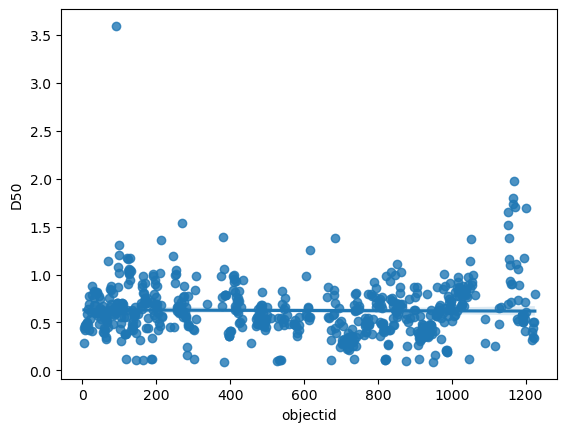

In [30]:
sns.regplot(x='objectid', y='D50', data=df)

In [31]:
df[df.D50 > 3.5]

,objectid,D10,D50,D90,DMEAN,date,lon,lat,B02,B03,B04,B05,B06,B07,B08,B8A,B11,B12,span
12,92,2.368181,3.595201,5.848548,3.621643,2021-06-11,-73.556896,40.580327,0.3112,0.3698,0.4276,0.4471,0.4493,0.4634,0.4892,0.4839,0.564,0.5708,0.968059


We know from a qualitative inspection of this observation that it had a bunch of shells in it, in an otherwise relatively homogenous grain distribution. 
Also there were many data points nearby which all had much lower D50. Hence, remove

In [32]:
df = df[df.objectid != 92].reset_index(drop=True)
df

,objectid,D10,D50,D90,DMEAN,date,lon,lat,B02,B03,B04,B05,B06,B07,B08,B8A,B11,B12,span
0,925,0.255204,0.386369,0.627979,0.389373,2022-11-12,-89.043261,30.377676,0.4176,0.4836,0.5532,0.5941,0.6111,0.6168,0.6596,0.6416,0.7193,0.7460,0.964816
1,261,0.423573,0.645732,1.052281,0.649902,2021-09-15,-122.511641,37.757227,0.0843,0.1042,0.1112,0.1297,0.1249,0.1273,0.1136,0.1324,0.2028,0.1973,0.973636
2,238,0.295365,0.447742,0.728023,0.451138,2021-09-15,-81.809414,24.545279,0.2698,0.3530,0.2552,0.4207,0.3683,0.3964,0.1422,0.3881,0.3201,0.2186,0.966310
3,215,0.369014,0.559148,0.909059,0.563421,2021-09-14,-81.264700,29.854100,0.2374,0.2850,0.2642,0.2219,0.1721,0.1788,0.2106,0.1681,0.1292,0.0860,0.965835
4,547,0.419892,0.635700,1.033225,0.640642,2022-05-03,-87.779766,42.739346,0.2408,0.2902,0.3362,0.3554,0.3828,0.3934,0.4188,0.4017,0.4815,0.4532,0.964816
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
636,100,0.794476,1.205290,1.960269,1.214298,2021-06-11,-73.561078,40.578827,0.2802,0.3292,0.3780,0.4047,0.4077,0.4181,0.4248,0.4316,0.4915,0.5042,0.967231
637,984,0.131369,0.198888,0.323259,0.200434,2022-11-21,-79.773942,32.790679,0.3796,0.4140,0.4292,0.4459,0.4419,0.4455,0.4604,0.4445,0.5194,0.5223,0.964816
638,492,0.313079,0.473989,0.770391,0.477674,2022-03-09,-119.194608,34.140937,0.1892,0.2190,0.2438,0.3213,0.3125,0.3238,0.2908,0.3165,0.3779,0.3611,0.964816
639,1033,0.533347,0.807466,1.312403,0.813744,2022-11-29,-76.225683,34.922580,0.2740,0.2950,0.3062,0.3282,0.3256,0.3316,0.3204,0.3296,0.3031,0.2927,0.964816


## Save file to disk

In [33]:
df.to_csv('../data/sandsnap-usa-s2-reflectance.csv')

## Regress D50/D90/D10

In [34]:
import statsmodels.formula.api as smf 
#["B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B11", "B12"]
# formula: response ~ predictor + predictor 
model = smf.ols(formula='D50 ~ B02 + B03 + B04 + B05 + B06 + B07 + B08 + B8A + B11 + B12', data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    D50   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     2.258
Date:                Tue, 14 Mar 2023   Prob (F-statistic):             0.0136
Time:                        18:33:31   Log-Likelihood:                -44.782
No. Observations:                 641   AIC:                             111.6
Df Residuals:                     630   BIC:                             160.7
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.7240      0.034     21.597      0.000       0.658       0.790
B02            0.0044      0.619      0.007      0.994      -1.210       1.219
B03           -0.0537      1.050     -0.051      0.959      -2.115       2.007
B04            0.7260      0.760      0.956      0.339      -0.765       2.218
B05           -0.3911      0.646     -0.606      0.545      -1.659       0.877
B06           -0.7776      1.071     -0.726      0.468      -2.882       1.327
B07           -0.6883      1.191     -0.578      0.564      -3.027       1.651
B08           -0.3568      0.416     -0.857      0.392      -1.174       0.461
B8A            1.8388      0.969      1.897      0.058      -0.065       3.743
B11           -0.9608      0.555     -1.730      0.084      -2.052       0.130
B12            0.4243      0.413      1.027      0.305      -0.387       1.236
==============================================================================
Omnibus:                      126.325   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              329.208
Skew:                           0.996   Prob(JB):                     3.26e-72
Kurtosis:                       5.891   Cond. No.                         215.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [35]:
import statsmodels.formula.api as smf 
#["B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B11", "B12"]
# formula: response ~ predictor + predictor 
model = smf.ols(formula='D90 ~ B02 + B03 + B04 + B05 + B06 + B07 + B08 + B8A + B11 + B12', data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    D90   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     2.267
Date:                Tue, 14 Mar 2023   Prob (F-statistic):             0.0131
Time:                        18:34:30   Log-Likelihood:                -356.36
No. Observations:                 641   AIC:                             734.7
Df Residuals:                     630   BIC:                             783.8
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.1780      0.055     21.611      0.000       1.071       1.285
B02            0.0060      1.006      0.006      0.995      -1.969       1.981
B03           -0.0860      1.707     -0.050      0.960      -3.437       3.265
B04            1.1797      1.235      0.955      0.340      -1.245       3.605
B05           -0.6360      1.050     -0.606      0.545      -2.697       1.425
B06           -1.2634      1.742     -0.725      0.469      -4.684       2.158
B07           -1.1207      1.937     -0.579      0.563      -4.924       2.683
B08           -0.5797      0.677     -0.857      0.392      -1.909       0.749
B8A            2.9884      1.576      1.896      0.058      -0.107       6.084
B11           -1.5642      0.903     -1.732      0.084      -3.338       0.209
B12            0.6922      0.672      1.030      0.303      -0.627       2.012
==============================================================================
Omnibus:                      125.882   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              327.193
Skew:                           0.994   Prob(JB):                     8.93e-72
Kurtosis:                       5.881   Cond. No.                         215.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [36]:
import statsmodels.formula.api as smf 
#["B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B11", "B12"]
# formula: response ~ predictor + predictor 
model = smf.ols(formula='D10 ~ B02 + B03 + B04 + B05 + B06 + B07 + B08 + B8A + B11 + B12', data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    D10   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     2.233
Date:                Tue, 14 Mar 2023   Prob (F-statistic):             0.0147
Time:                        18:34:30   Log-Likelihood:                 221.65
No. Observations:                 641   AIC:                            -421.3
Df Residuals:                     630   BIC:                            -372.2
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4770      0.022     21.560      0.000       0.434       0.520
B02            0.0036      0.408      0.009      0.993      -0.798       0.805
B03           -0.0358      0.693     -0.052      0.959      -1.396       1.324
B04            0.4792      0.501      0.956      0.339      -0.505       1.463
B05           -0.2578      0.426     -0.605      0.545      -1.094       0.579
B06           -0.5139      0.707     -0.727      0.468      -1.902       0.875
B07           -0.4527      0.786     -0.576      0.565      -1.996       1.091
B08           -0.2356      0.275     -0.858      0.391      -0.775       0.304
B8A            1.2145      0.640      1.898      0.058      -0.042       2.471
B11           -0.6317      0.367     -1.723      0.085      -1.352       0.088
B12            0.2772      0.273      1.016      0.310      -0.258       0.813
==============================================================================
Omnibus:                      127.453   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              334.326
Skew:                           1.002   Prob(JB):                     2.52e-73
Kurtosis:                       5.915   Cond. No.                         215.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    D50   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     16.97
Date:                Tue, 14 Mar 2023   Prob (F-statistic):           4.31e-05
Time:                        18:34:34   Log-Likelihood:                -47.667
No. Observations:                 641   AIC:                             99.33
Df Residuals:                     639   BIC:                             108.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.7203      0.026     27.228      0.000       0.668       0.772
B11           -0.2688      0.065     -4.119      0.000      -0.397      -0.141
==============================================================================
Omnibus:                      132.317   Durbin-Watson:                   1.974
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              358.389
Skew:                           1.028   Prob(JB):                     1.50e-78
Kurtosis:                       6.032   Cond. No.                         7.23
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    D90   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     17.07
Date:                Tue, 14 Mar 2023   Prob (F-statistic):           4.09e-05
Time:                        18:34:34   Log-Likelihood:                -359.24
No. Observations:                 641   AIC:                             722.5
Df Residuals:                     639   BIC:                             731.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.1718      0.043     27.241      0.000       1.087       1.256
B11           -0.4384      0.106     -4.131      0.000      -0.647      -0.230
==============================================================================
Omnibus:                      131.844   Durbin-Watson:                   1.974
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              356.147
Skew:                           1.025   Prob(JB):                     4.61e-78
Kurtosis:                       6.022   Cond. No.                         7.23
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    D10   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     16.72
Date:                Tue, 14 Mar 2023   Prob (F-statistic):           4.89e-05
Time:                        18:34:34   Log-Likelihood:                 218.77
No. Observations:                 641   AIC:                            -433.5
Df Residuals:                     639   BIC:                            -424.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4747      0.017     27.193      0.000       0.440       0.509
B11           -0.1761      0.043     -4.089      0.000      -0.261      -0.092
==============================================================================
Omnibus:                      133.523   Durbin-Watson:                   1.974
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              364.090
Skew:                           1.034   Prob(JB):                     8.69e-80
Kurtosis:                       6.058   Cond. No.                         7.23
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

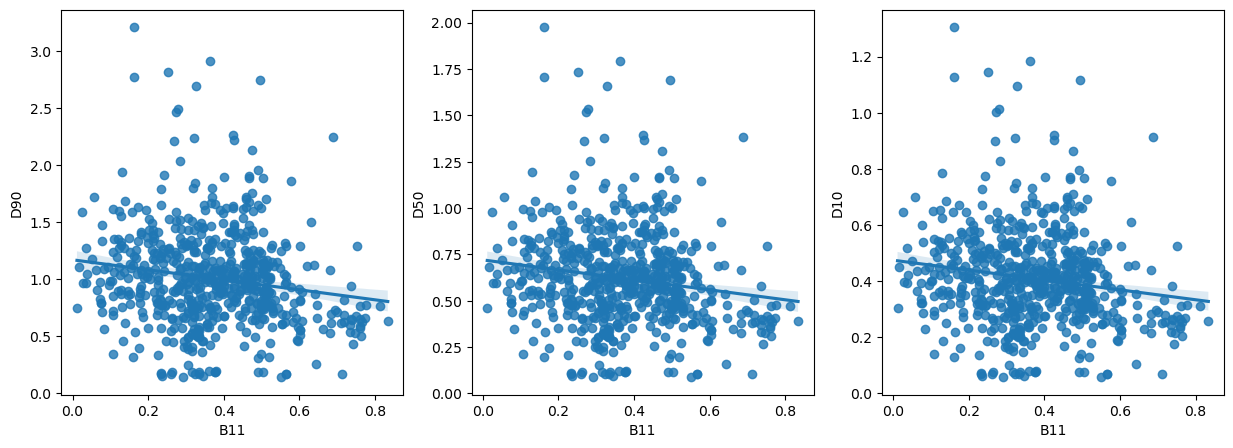

In [37]:
model2 = smf.ols(formula='D50 ~ B11', data=df).fit()
model1 = smf.ols(formula='D90 ~ B11', data=df).fit()
model3 = smf.ols(formula='D10 ~ B11', data=df).fit()
display(model2.summary())
display(model1.summary())
display(model3.summary())

fig, axs = plt.subplots(1, 3, sharex=True, figsize=(15,5))

sns.regplot(x='B11', y='D50', data=df, ax=axs[1])
sns.regplot(x='B11', y='D90', data=df, ax=axs[0])
sns.regplot(x='B11', y='D10', data=df, ax=axs[2])
plt.show()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    D50   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     12.99
Date:                Tue, 14 Mar 2023   Prob (F-statistic):           0.000338
Time:                        18:34:59   Log-Likelihood:                -49.616
No. Observations:                 641   AIC:                             103.2
Df Residuals:                     639   BIC:                             112.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.7130      0.028     25.639      0.000       0.658       0.768
B8A           -0.2556      0.071     -3.604      0.000      -0.395      -0.116
==============================================================================
Omnibus:                      134.449   Durbin-Watson:                   1.966
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              365.408
Skew:                           1.042   Prob(JB):                     4.50e-80
Kurtosis:                       6.055   Cond. No.                         7.78
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<AxesSubplot:xlabel='B8A', ylabel='D50'>

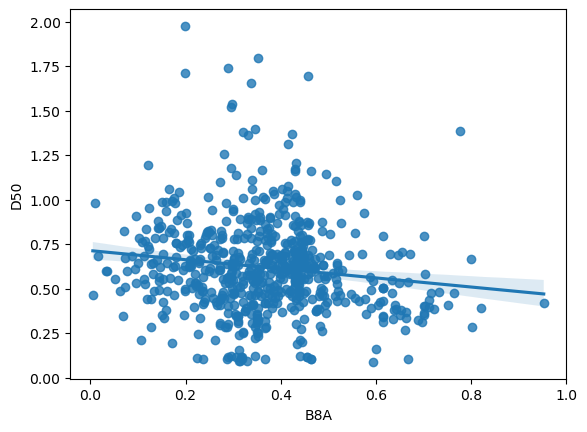

In [38]:
model_hom = smf.ols(formula='D50 ~ B8A', data=df).fit()
display(model_hom.summary())
sns.regplot(x='B8A', y='D50', data=df)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    D50   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     9.051
Date:                Tue, 14 Mar 2023   Prob (F-statistic):            0.00273
Time:                        18:35:14   Log-Likelihood:                -51.557
No. Observations:                 641   AIC:                             107.1
Df Residuals:                     639   BIC:                             116.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.6925      0.026     26.391      0.000       0.641       0.744
B04           -0.2242      0.075     -3.009      0.003      -0.371      -0.078
==============================================================================
Omnibus:                      137.690   Durbin-Watson:                   1.963
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              388.573
Skew:                           1.053   Prob(JB):                     4.19e-85
Kurtosis:                       6.180   Cond. No.                         7.95
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<AxesSubplot:xlabel='B04', ylabel='D50'>

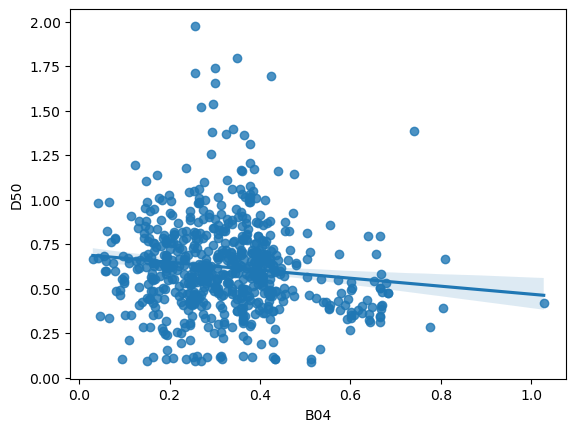

In [39]:
model_con = smf.ols(formula='D50 ~ B04', data=df).fit()
display(model_con.summary())
sns.regplot(x='B04', y='D50', data=df)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    D50   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     11.85
Date:                Tue, 14 Mar 2023   Prob (F-statistic):           0.000614
Time:                        18:35:24   Log-Likelihood:                -50.176
No. Observations:                 641   AIC:                             104.4
Df Residuals:                     639   BIC:                             113.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.7037      0.026     26.618      0.000       0.652       0.756
B08           -0.2288      0.066     -3.442      0.001      -0.359      -0.098
==============================================================================
Omnibus:                      135.736   Durbin-Watson:                   1.962
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              373.803
Skew:                           1.047   Prob(JB):                     6.76e-82
Kurtosis:                       6.100   Cond. No.                         7.30
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<AxesSubplot:xlabel='B08', ylabel='D50'>

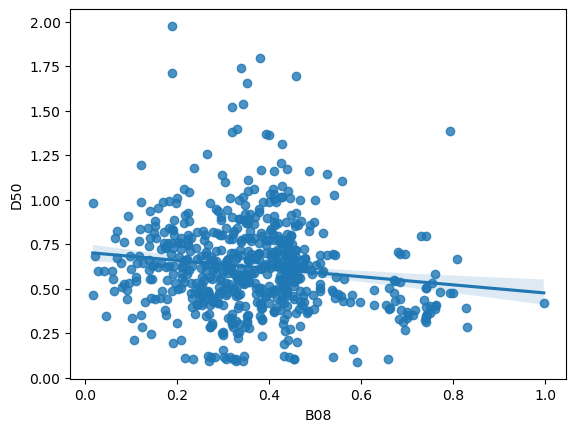

In [40]:
model = smf.ols(formula='D50 ~ B08', data=df).fit()
display(model.summary())
sns.regplot(x='B08', y='D50', data=df)
# plt.scatter(usa['correlation'], usa['D50'])
# plt.plot(model_corr,linestyle ='dotted')
# plt.xlabel('correlation')
# plt.ylabel('D50')
# plt.show()

# Random Forest Regression

Clearly no linearity can be found at these spatial scale (0.6m). This is likely telling us that the texture features are all but lost at this resolution for detecting particle sizes of this size (<2mm)

In [75]:
df.head()

,objectid,D10,D50,D90,DMEAN,date,lon,lat,B02,B03,B04,B05,B06,B07,B08,B8A,B11,B12,span
0,925,0.255204,0.386369,0.627979,0.389373,2022-11-12,-89.043261,30.377676,4176.0,4836.0,5532.0,5941.0,6111.0,6168.0,6596.0,6416.0,7193.0,7460.0,0.964816
1,261,0.423573,0.645732,1.052281,0.649902,2021-09-15,-122.511641,37.757227,843.0,1042.0,1112.0,1297.0,1249.0,1273.0,1136.0,1324.0,2028.0,1973.0,0.973636
2,238,0.295365,0.447742,0.728023,0.451138,2021-09-15,-81.809414,24.545279,2698.0,3530.0,2552.0,4207.0,3683.0,3964.0,1422.0,3881.0,3201.0,2186.0,0.966310
3,215,0.369014,0.559148,0.909059,0.563421,2021-09-14,-81.264700,29.854100,2374.0,2850.0,2642.0,2219.0,1721.0,1788.0,2106.0,1681.0,1292.0,860.0,0.965835
4,547,0.419892,0.635700,1.033225,0.640642,2022-05-03,-87.779766,42.739346,2408.0,2902.0,3362.0,3554.0,3828.0,3934.0,4188.0,4017.0,4815.0,4532.0,0.964816


In [53]:
y = df['D50']
X = df[BANDS]
display(X)
display(y)
type(y)

,B02,B03,B04,B05,B06,B07,B08,B8A,B11,B12
0,0.4176,0.4836,0.5532,0.5941,0.6111,0.6168,0.6596,0.6416,0.7193,0.7460
1,0.0843,0.1042,0.1112,0.1297,0.1249,0.1273,0.1136,0.1324,0.2028,0.1973
2,0.2698,0.3530,0.2552,0.4207,0.3683,0.3964,0.1422,0.3881,0.3201,0.2186
3,0.2374,0.2850,0.2642,0.2219,0.1721,0.1788,0.2106,0.1681,0.1292,0.0860
4,0.2408,0.2902,0.3362,0.3554,0.3828,0.3934,0.4188,0.4017,0.4815,0.4532
...,...,...,...,...,...,...,...,...,...,...
636,0.2802,0.3292,0.3780,0.4047,0.4077,0.4181,0.4248,0.4316,0.4915,0.5042
637,0.3796,0.4140,0.4292,0.4459,0.4419,0.4455,0.4604,0.4445,0.5194,0.5223
638,0.1892,0.2190,0.2438,0.3213,0.3125,0.3238,0.2908,0.3165,0.3779,0.3611
639,0.2740,0.2950,0.3062,0.3282,0.3256,0.3316,0.3204,0.3296,0.3031,0.2927


0      0.386369
1      0.645732
2      0.447742
3      0.559148
4      0.635700
         ...   
636    1.205290
637    0.198888
638    0.473989
639    0.807466
640    0.825148
Name: D50, Length: 641, dtype: float64

pandas.core.series.Series

In [72]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

In [62]:
del predictions, rf

In [63]:
# Train the model
rf = RandomForestRegressor(n_estimators = 10, max_depth = 10, random_state = 42)
rf.fit(X_train, y_train.values.ravel())

RandomForestRegressor(max_depth=10, n_estimators=10, random_state=42)

In [64]:
import warnings
warnings.filterwarnings('ignore')

# Make prediction
predictions = rf.predict(X_test)

result = X_test.copy()
result['D50'] = y_test
result['D50_pred'] = predictions.tolist()
result.head()

,B02,B03,B04,B05,B06,B07,B08,B8A,B11,B12,D50,D50_pred
86,0.2544,0.3100,0.3616,0.4108,0.4112,0.4261,0.4312,0.4407,0.4904,0.4836,0.118306,0.605238
304,0.1492,0.1655,0.1750,0.2327,0.2688,0.3062,0.2382,0.3040,0.2890,0.2622,0.355716,0.406339
434,0.2208,0.2566,0.2766,0.2705,0.2629,0.2799,0.3036,0.2729,0.2337,0.1863,1.101147,0.556855
312,0.3292,0.3592,0.3718,0.4073,0.4227,0.4240,0.4416,0.4404,0.4979,0.4717,0.211075,0.635244
72,0.2276,0.2478,0.2532,0.2568,0.2494,0.2557,0.2678,0.2588,0.2333,0.1803,0.742600,0.480772


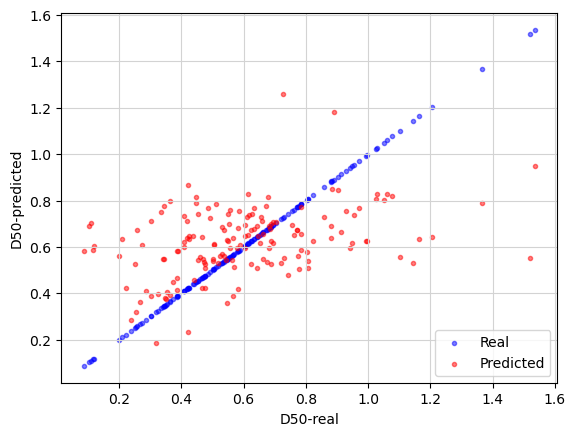

In [66]:
import matplotlib.pyplot as plt

# Define x axis
x_axis = X_test.D50

# Build scatterplot
plt.scatter(x_axis, y_test, c = 'b', alpha = 0.5, marker = '.', label = 'Real')
plt.scatter(x_axis, predictions, c = 'r', alpha = 0.5, marker = '.', label = 'Predicted')
plt.xlabel('D50-real')
plt.ylabel('D50-predicted')
plt.grid(color = '#D3D3D3', linestyle = 'solid')
plt.legend(loc = 'lower right')
plt.show()

## Tuning hyperparameters

In [68]:
# Import GridSearchCV
from sklearn.model_selection import GridSearchCV

# Find the best parameters for the model
parameters = {
    'max_depth': [70, 80, 90, 100],
    'n_estimators': [900, 1000, 1100]
}
gridforest = GridSearchCV(rf, parameters, cv = 3, n_jobs = -1, verbose = 1)
gridforest.fit(X_train, y_train)
gridforest.best_params_

Fitting 3 folds for each of 12 candidates, totalling 36 fits


{'max_depth': 70, 'n_estimators': 1100}

In [69]:
rf = RandomForestRegressor(n_estimators = 1100, max_depth = 70, random_state = 42)
rf.fit(X_train, y_train.values.ravel())

RandomForestRegressor(max_depth=70, n_estimators=1100, random_state=42)

In [71]:
X_test

,B02,B03,B04,B05,B06,B07,B08,B8A,B11,B12,D50,D50_pred
86,0.2544,0.3100,0.3616,0.4108,0.4112,0.4261,0.4312,0.4407,0.4904,0.4836,0.118306,0.605238
304,0.1492,0.1655,0.1750,0.2327,0.2688,0.3062,0.2382,0.3040,0.2890,0.2622,0.355716,0.406339
434,0.2208,0.2566,0.2766,0.2705,0.2629,0.2799,0.3036,0.2729,0.2337,0.1863,1.101147,0.556855
312,0.3292,0.3592,0.3718,0.4073,0.4227,0.4240,0.4416,0.4404,0.4979,0.4717,0.211075,0.635244
72,0.2276,0.2478,0.2532,0.2568,0.2494,0.2557,0.2678,0.2588,0.2333,0.1803,0.742600,0.480772
...,...,...,...,...,...,...,...,...,...,...,...,...
449,0.3280,0.3596,0.3754,0.4751,0.4743,0.4750,0.4468,0.4972,0.4116,0.3747,0.567639,0.637438
507,0.1052,0.1368,0.1464,0.1411,0.1261,0.1260,0.1592,0.1223,0.1289,0.1128,0.954009,0.739702
596,0.2696,0.3094,0.3214,0.3519,0.3619,0.3433,0.3192,0.3496,0.3345,0.2871,0.302498,0.389263
521,0.2186,0.2714,0.2964,0.2504,0.2656,0.2770,0.3440,0.2979,0.2787,0.2520,1.535675,0.948572


In [73]:
# Make prediction
predictions = rf.predict(X_test)

result = X_test.copy()
result['D50'] = y_test
result['D50_pred'] = predictions.tolist()
result.head()

,B02,B03,B04,B05,B06,B07,B08,B8A,B11,B12,D50,D50_pred
86,0.2544,0.3100,0.3616,0.4108,0.4112,0.4261,0.4312,0.4407,0.4904,0.4836,0.118306,0.598686
304,0.1492,0.1655,0.1750,0.2327,0.2688,0.3062,0.2382,0.3040,0.2890,0.2622,0.355716,0.463426
434,0.2208,0.2566,0.2766,0.2705,0.2629,0.2799,0.3036,0.2729,0.2337,0.1863,1.101147,0.572464
312,0.3292,0.3592,0.3718,0.4073,0.4227,0.4240,0.4416,0.4404,0.4979,0.4717,0.211075,0.650336
72,0.2276,0.2478,0.2532,0.2568,0.2494,0.2557,0.2678,0.2588,0.2333,0.1803,0.742600,0.491687


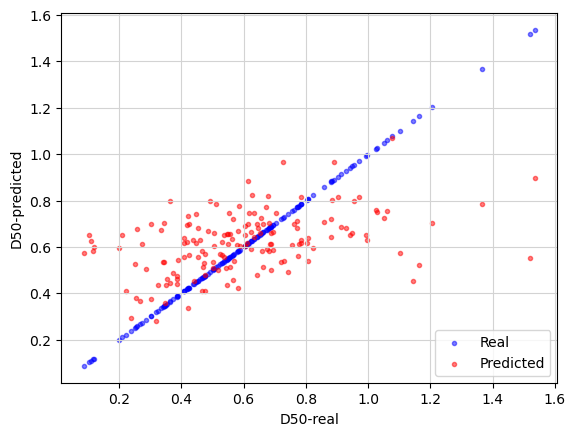

In [75]:
# Define x axis
x_axis = result.D50

# Build scatterplot
plt.scatter(x_axis, y_test, c = 'b', alpha = 0.5, marker = '.', label = 'Real')
plt.scatter(x_axis, predictions, c = 'r', alpha = 0.5, marker = '.', label = 'Predicted')
plt.xlabel('D50-real')
plt.ylabel('D50-predicted')
plt.grid(color = '#D3D3D3', linestyle = 'solid')
plt.legend(loc = 'lower right')
plt.show()

## Error Estimation

In [76]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Mean absolute error (MAE)
mae = mean_absolute_error(y_test.values.ravel(), predictions)

# Mean squared error (MSE)
mse = mean_squared_error(y_test.values.ravel(), predictions)

# R-squared scores
r2 = r2_score(y_test.values.ravel(), predictions)

# Print metrics
print('Mean Absolute Error:', round(mae, 2))
print('Mean Squared Error:', round(mse, 2))
print('R-squared scores:', round(r2, 2))

Mean Absolute Error: 0.18
Mean Squared Error: 0.06
R-squared scores: 0.18


## Defining and visualizing variables importance

In [78]:
# Get features list
characteristics = X.columns
# Get the variables importances, sort them, and print the result
importances = list(rf.feature_importances_)
characteristics_importances = [(characteristic, round(importance, 2)) for characteristic, importance in zip(characteristics, importances)]
characteristics_importances = sorted(characteristics_importances, key = lambda x: x[1], reverse = True)
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in characteristics_importances];

Variable: B11                  Importance: 0.12
Variable: B12                  Importance: 0.12
Variable: B04                  Importance: 0.11
Variable: B05                  Importance: 0.11
Variable: B08                  Importance: 0.11
Variable: B02                  Importance: 0.1
Variable: B03                  Importance: 0.1
Variable: B8A                  Importance: 0.09
Variable: B06                  Importance: 0.08
Variable: B07                  Importance: 0.06


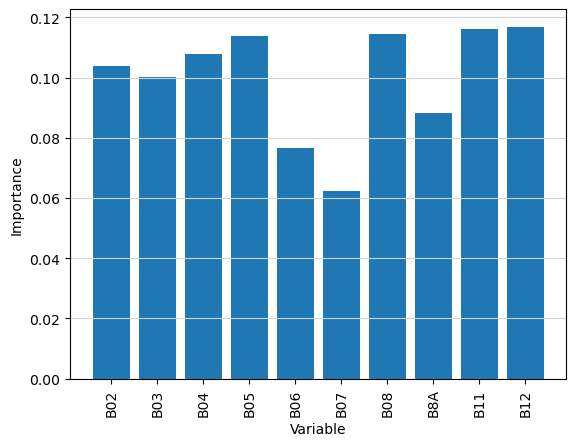

In [79]:
# Visualize the variables importances
plt.bar(characteristics, importances, orientation = 'vertical')
plt.xticks(rotation = 'vertical')
plt.ylabel('Importance')
plt.xlabel('Variable')
plt.grid(axis = 'y', color = '#D3D3D3', linestyle = 'solid')
plt.show()